# 1. Import required libraries

In [150]:
# Import required dependencies
import boto3
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from datetime import datetime

# from collections import Counter
# import shap

# 2. Read data

In [151]:
# Readind data
bucket_name = 'finance-factoring-ml-dev'

df = pd.read_csv('s3://{}/data/all.csv'.format(bucket_name))
df.head()

,Fecha,RFCCliente,RFCPagador,Moneda,FechaVencimiento,Monto,DepositoInicial,Intereses,FechaPago
0,1918.0,DDI140206JB6,0,1,1953.0,38879.48,33047.56,2351.94,1939.0
1,1634.0,GOSJ630117VA4,1,0,1654.0,6658.40,5659.64,109.45,1638.0
2,1583.0,ECM190924RS5,2,1,1551.0,791.12,791.12,29.26,1551.0
3,2282.0,DIM9811232SA,3,0,2225.0,33048.00,28090.80,814.88,2226.0
4,2110.0,SNO200526BV7,4,0,2170.0,424634.82,360939.60,10615.87,2166.0


# 3. Data Engineering

In [152]:
# Remove RFC Columns
# df.drop("RFCPagador", axis=1, inplace=True)
df.drop("Moneda", axis=1, inplace=True)
df.drop("DepositoInicial", axis=1, inplace=True)
df.head()

,Fecha,RFCCliente,RFCPagador,FechaVencimiento,Monto,Intereses,FechaPago
0,1918.0,DDI140206JB6,0,1953.0,38879.48,2351.94,1939.0
1,1634.0,GOSJ630117VA4,1,1654.0,6658.40,109.45,1638.0
2,1583.0,ECM190924RS5,2,1551.0,791.12,29.26,1551.0
3,2282.0,DIM9811232SA,3,2225.0,33048.00,814.88,2226.0
4,2110.0,SNO200526BV7,4,2170.0,424634.82,10615.87,2166.0


In [153]:
# Build feature Payment term
def calc_payment_term(row):
    return row.FechaVencimiento - row.Fecha

df['PaymentTerm'] = df.apply(calc_payment_term, axis=1)
df.head()

,Fecha,RFCCliente,RFCPagador,FechaVencimiento,Monto,Intereses,FechaPago,PaymentTerm
0,1918.0,DDI140206JB6,0,1953.0,38879.48,2351.94,1939.0,35.0
1,1634.0,GOSJ630117VA4,1,1654.0,6658.40,109.45,1638.0,20.0
2,1583.0,ECM190924RS5,2,1551.0,791.12,29.26,1551.0,-32.0
3,2282.0,DIM9811232SA,3,2225.0,33048.00,814.88,2226.0,-57.0
4,2110.0,SNO200526BV7,4,2170.0,424634.82,10615.87,2166.0,60.0


In [202]:
df1 = df.loc[:, ['Monto', 'PaymentTerm']]
df1.head()

,Monto,PaymentTerm
0,38879.48,35.0
1,6658.40,20.0
2,791.12,-32.0
3,33048.00,-57.0
4,424634.82,60.0


In [203]:
# Remove Payment Term with negative values
df1 = df1[df1['PaymentTerm'] >= 0]
df1.head()

,Monto,PaymentTerm
0,38879.48,35.0
1,6658.40,20.0
4,424634.82,60.0
6,33220.66,43.0
8,304240.26,21.0


In [204]:
df1.describe()

,Monto,PaymentTerm
count,1.603900e+04,16039.000000
mean,3.872179e+04,88.773552
std,1.406455e+05,74.505099
min,2.960000e+00,0.000000
25%,1.573110e+03,46.000000
50%,8.280000e+03,64.000000
75%,2.810390e+04,93.000000
max,5.486111e+06,597.000000


In [205]:
#Normalizo la columna de Monto
# df1['Monto'] = df1['Monto'] /df1['Monto'].abs().max() 
# df1['PaymentTerm'] = df1['PaymentTerm'] /df1['PaymentTerm'].abs().max() 
from sklearn.preprocessing import MinMaxScaler 
import numpy as np 

df1['Monto'] = MinMaxScaler().fit_transform(np.array(df1['Monto']).reshape(-1,1)) 
df1['PaymentTerm'] = MinMaxScaler().fit_transform(np.array(df1['PaymentTerm']).reshape(-1,1)) 
df1.head()

,Monto,PaymentTerm
0,0.007086,0.058626
1,0.001213,0.033501
4,0.077401,0.100503
6,0.006055,0.072027
8,0.055456,0.035176


In [206]:
df1.describe()

,Monto,PaymentTerm
count,16039.000000,16039.000000
mean,0.007058,0.148699
std,0.025637,0.124799
min,0.000000,0.000000
25%,0.000286,0.077052
50%,0.001509,0.107203
75%,0.005122,0.155779
max,1.000000,1.000000


# Obtener el valor K

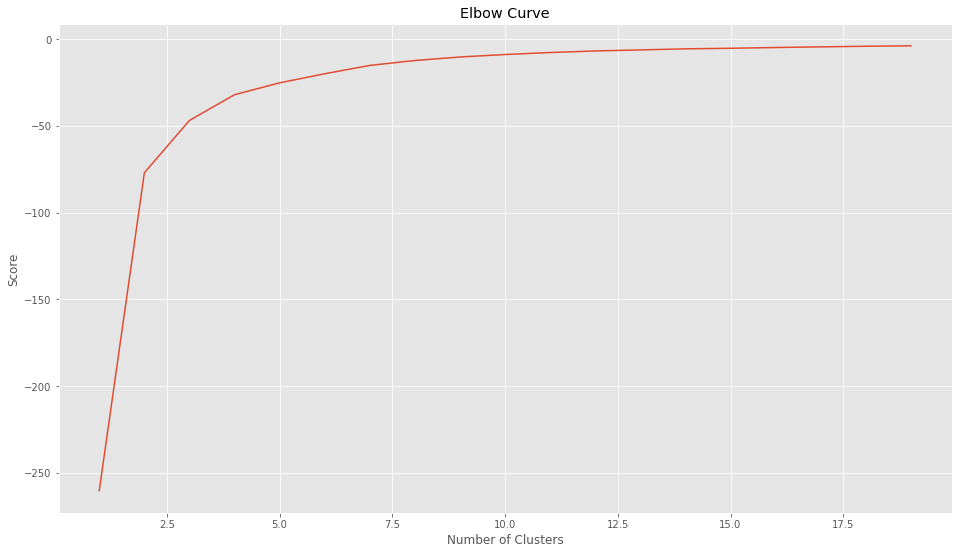

In [207]:
clusters_qty = range(1, 20)
kmeans_list = [KMeans(n_clusters=i) for i in clusters_qty]

score = [kmeans_list[i].fit(df1).score(df1) for i in range(len(kmeans_list))]
score
plt.plot(clusters_qty,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [208]:
# Take 4 as the elbow
n_clusters =4

kmeans = KMeans(n_clusters=n_clusters).fit(df1)
centroids = kmeans.cluster_centers_
print(centroids)

[[0.00568964 0.07575556]
 [0.0050844  0.52447555]
 [0.00744774 0.31318347]
 [0.01005735 0.15635014]]


[0 0 0 ... 0 0 0]


/tmp/ipykernel_8166/2092775458.py:14: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


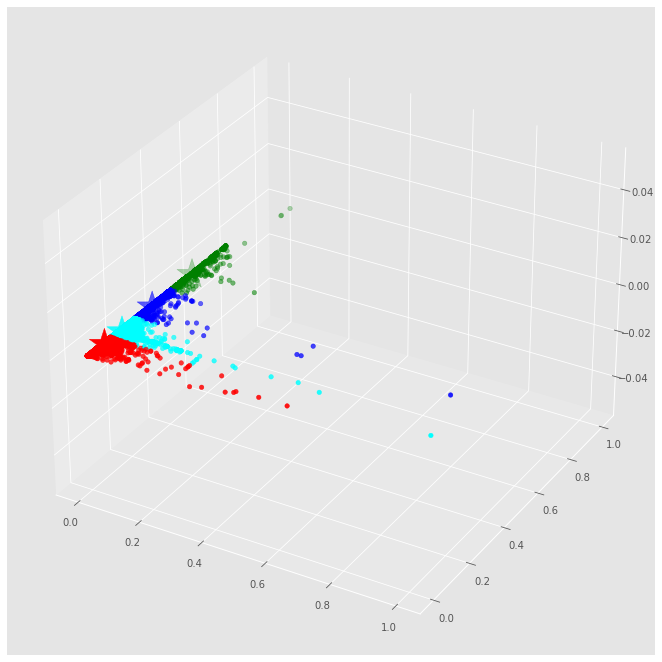

In [209]:
# Predicting the clusters
labels = kmeans.predict(df1)
print(labels)
# Getting the cluster centers
cluster_centers = kmeans.cluster_centers_

# Define colors according to the number of clusters
colors=['red','green','blue','cyan','yellow', 'gray']
asignar=[]
for row in labels:
    asignar.append(colors[row])

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(df1.iloc[:, 0], df1.iloc[:, 1], c=asignar,s=20)
ax.scatter(cluster_centers[:, 0],cluster_centers[:, 1], marker='*', c=colors[:n_clusters], s=1000)


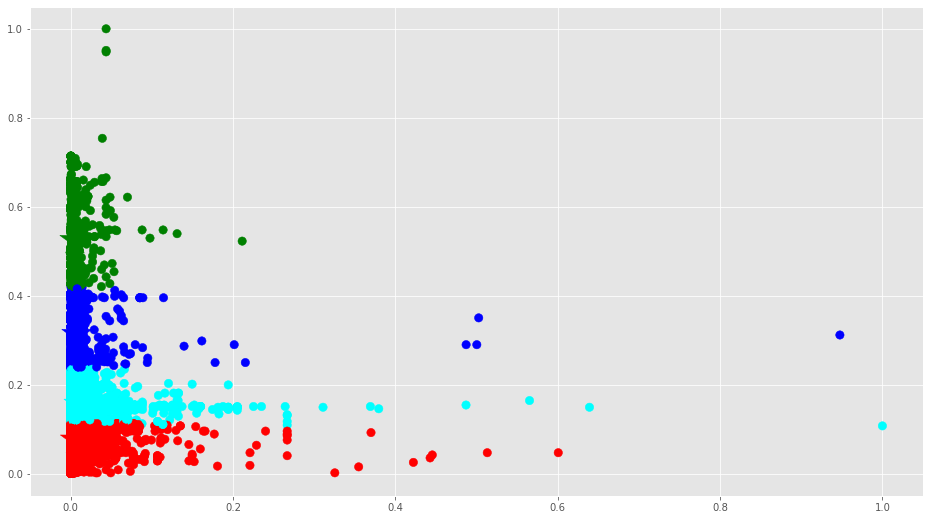

In [210]:
f1 = df1['Monto'].values
f2 = df1['PaymentTerm'].values
 
plt.scatter(f1, f2, c=asignar, s=70)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='*', c=colors[:n_clusters], s=1000)
# plt.show()

In [211]:
X_new = np.array([[6658.40, 20.0]]) #davidguetta

X_new = pd.DataFrame(np.array([[2.40, 1500.0]]), columns=['Monto', 'PaymentTerm'])

new_labels = kmeans.predict(X_new)
print(new_labels)

[1]
